### Descrizione del progetto

* L'obiettivo di questo progetto è quello di progettare un sistema in grado di classificare immagini di dimensione **28x28 pixel**, 
ciascuna rappresentante una lettera statica dell'alfabeto ASL (American Sign Language). Si escludono le lettere Y e Z poiché richiedono movimento.

* Verranno confrontati e valutati diversi modelli di Machine Learning affrontati durante il corso, al fine di identificare quello con la migliore combinazione di accuratezza e capacità di generalizzazione.

* I modelli analizzati saranno:
  - **Naive Bayes**
  - **MLPClassifier**
  - **SVM**
  - **Decision Tree**

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [63]:
# Dizionario per mappare i numeri (0-25) alle lettere dell'alfabeto ASL per una migliore interpretazione delle classificazioni.
lettereALS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L', 'M',
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
keys = list(range(26))
Lettere_keys = dict(zip(keys, lettereALS))


**1. Visualizzazione dei Dataset**

In [64]:
def visualize_dataset(dataset, str):
    '''
    Visualizza i primi 5 campioni del dataset. 
    Ogni immagine viene mostrata in una griglia 28x28 in scala di grigi, 
    con la lettera corrispondente.
    
    Args:
        dataset (pd.DataFrame): dataset
    '''
    # Statistiche di base
    print(dataset.head())
    print("Statistiche del dataset:")
    print(f"Numero di campioni: {dataset.shape[0]}")
    print(f"Numero di features: {dataset.shape[1]}")

    fig, axes = plt.subplots(1,5,figsize=(10, 3))
    fig.suptitle(f"Anteprima del dataset di {str}")
    for i, ax in enumerate(axes):
        target = dataset.iloc[i].values[0]
        pixels = dataset.iloc[i].values[1:]
        ax.imshow(pixels.reshape(28,28), cmap='gray')
        ax.set_title(f"{target} = {Lettere_keys[target]}")

    plt.show()

**2. Caricamento dei Dataset**

In [65]:
def load_datasets(train_path,test_path ):
    '''
    Carica i dataset di training e di testing e restituisce le feature e i 
    target separatamente.

    ARGS (str): 
        train_path (str): path del dataset di train
        test_path (str): path del dataset di test

    RETURNS:  
        tuple: x_train, y_train, x_test, y_test
    '''

    Train_data = pd.read_csv(train_path)
    Test_data = pd.read_csv(test_path)

    print("VISUALIZZAZIONE DATASET DI TRAIN")
    visualize_dataset(Train_data, "train")
    print("VISUALIZZAZIONE DATASET DI TEST")
    visualize_dataset(Test_data, "test")
    
    x_test = Test_data.iloc[:,1:].values
    y_test = Test_data.iloc[:,0].values

    x_train = Train_data.iloc[:,1:].values
    y_train = Train_data.iloc[:,0].values

    return x_train, y_train, x_test, y_test

**3. Exploratory Data Analisys (EDA)**

In [66]:
def perform_eda(X,y, dataset_name):
    '''
    Esegue l'analisi esplorativa dei dati analizzando la distribuzione delle classi
    e i valori dei pixel nel dataset. 

    Args:
        X (np.array): features
        y (np.array): target
    '''

    # Distribuzione delle classi
    plt.figure(figsize=(12,4))
    plt.suptitle(f"Distribuzione delle classi - {dataset_name}")
    plt.subplot(121)
    sns.histplot(y.flatten(), bins=np.arange(-0.5, 26.5, 1), color='red', alpha=0.7, edgecolor='black' )
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.title("Distribuzione delle classi")
    plt.xlabel("Classe")
    plt.ylabel("Conteggio")
    plt.xticks(keys, Lettere_keys.values())

    # Distribuzione dei pixel
    plt.subplot(122)
    plt.hist(X.flatten(), bins=256, color='blue', alpha=0.7)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.title("Distribuzione dei Valori dei Pixel")
    plt.xlabel("Valore del Pixel")
    plt.ylabel("Frequenza")
    plt.tight_layout()

    plt.show()

**4. Preprocessing**

In [67]:
def PCA_preprocess(x_train, x_test, n_components=0.95):
    '''
    Applica la PCA sui dati di addestramento e di test, riducendo la dimensionalità
    mantenendo una percentuale di varianza (default 95%).
    
    Args:
        x_train (np.array): features di train
        x_test (np.array): features di test
        n_components (float): la percentuale di varianza da mantenere
        
    Returns:
        tuple: x_train, x_test
    ''' 

    print(f"Numero di features prima della PCA: {x_train.shape}")
    
    
    pca = PCA(n_components=n_components)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    return x_train, x_test

In [68]:
def preprocess_data(x_train, x_test):
    '''
    Preprocessing dei dati: I dati vengono normalizzati per ottimizzare le performance
    dei modelli di Machine Learning.

    Args:
        x_train (np.array): features di train
        y_train (np.array): target di train
        x_test (np.array): features di test
        y_test (np.array): target di test

    Returns:
        tuple: x_train, y_train, x_test, y_test
    '''
    
    normalizer = StandardScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)  

    return x_train, x_test

**5. Modelli Utilizzati**

In [69]:
def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    '''
    Esegui l'addestramento e l'evaluazione dei modelli

    Args:
        x_train (np.array): features di train
        y_train (np.array): target di train
        x_test (np.array): features di test
        y_test (np.array): target di test

    Returns:
        dict: Risultati per ogni modello (accuracy, F1-score, modello)
        best_model: Il miglior modello basato su accuracy e
    '''  

    # Modelli usati durante l'addestramento
    models = {
        'Naive Bayes': GaussianNB(),
        'MLPClassifier1': MLPClassifier(
            hidden_layer_sizes=(256, 128, 64), 
            activation='relu',
            solver='adam',
            max_iter=5000,
            n_iter_no_change=10,
            random_state=42,
            alpha=0.0001,
        ),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=25, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        # Addestramento
        model.fit(x_train, y_train)
        
        # Predizioni
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Accuracy {name}: {accuracy:.2f}")
        print(f"F1-Score {name}: {f1:.2f}")

        # Salva i risultati
        results[name] = {'accuracy': accuracy, 'f1_score': f1, 'model':model}

        # Stampa report di classificazione
        print(f"\nClassification Report - {name}:\n")
        print(classification_report(y_test, y_pred))

        # Matrice di confusione
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Matrice di Confusione - {name}')
        plt.xlabel('Predetto')
        plt.ylabel('Vero')
        plt.show()

    # Trova il modello migliore basato su accuracy e F1-Score
    best_model_name = max(results, key=lambda name: (results[name]['accuracy'], results[name]['f1_score']))
    best_model = results[best_model_name]['model']
    print(f"\nMiglior modello: {best_model_name}")
    print(f"Accuratezza: {results[best_model_name]['accuracy']:.2f}")
    print(f"F1-Score: {results[best_model_name]['f1_score']:.2f}\n")

    # Confronto delle performance
    model_names = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in model_names]
    f1_scores = [results[model]['f1_score'] for model in model_names]

    # Grafico comparativo
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    plt.bar(x - 0.2, accuracies, 0.4, label='Accuracy', color='blue')
    plt.bar(x + 0.2, f1_scores, 0.4, label='F1-Score', color='green')
    plt.xticks(x, model_names, rotation=15)
    plt.title('Confronto Performance Modelli')
    plt.xlabel('Modelli')
    plt.ylabel('Metriche')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    return results, best_model


VISUALIZZAZIONE DATASET DI TRAIN
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784

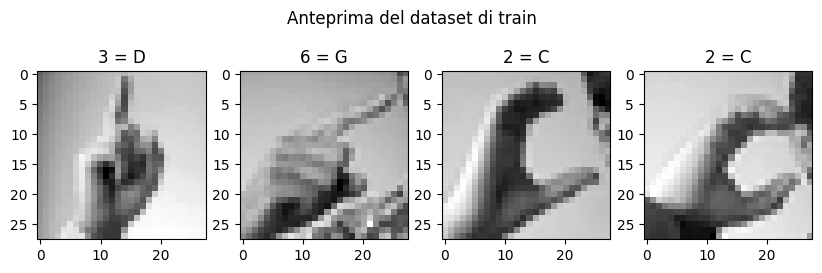

VISUALIZZAZIONE DATASET DI TEST
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     150   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   
3      0     203     205     207     206     207     209     210     209   
4      3     188     191     193     195     199     201     202     203   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     151  ...       138       148       127        89        82        96   
1     136  ...        47       104       194       183       186       184   
2     147  ...        68       166       242       227       230       227   
3     210  ...       154       248       247       248       253       236   
4     203  ...        26        40        64        48        29        46   

   pixel781  pixel782  pixel783  pixel784 

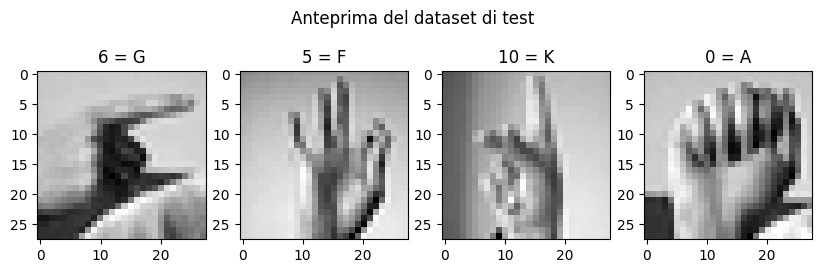

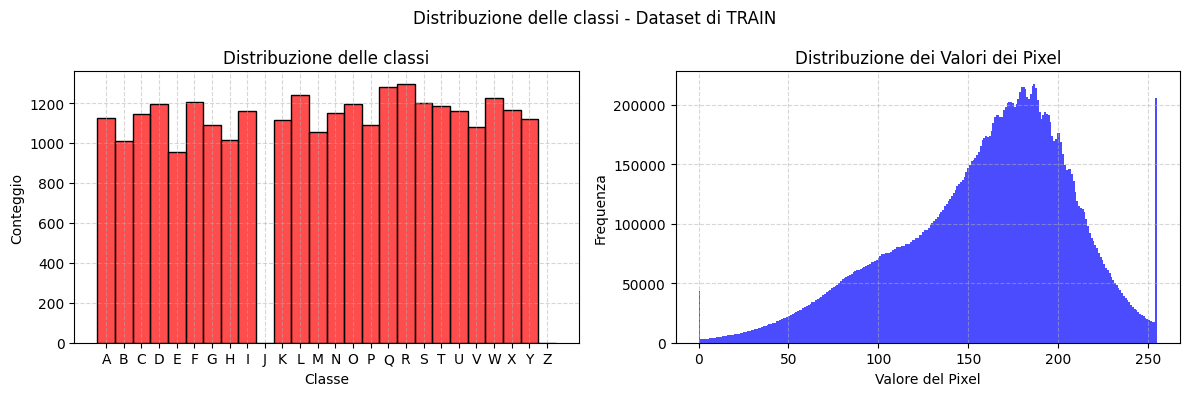

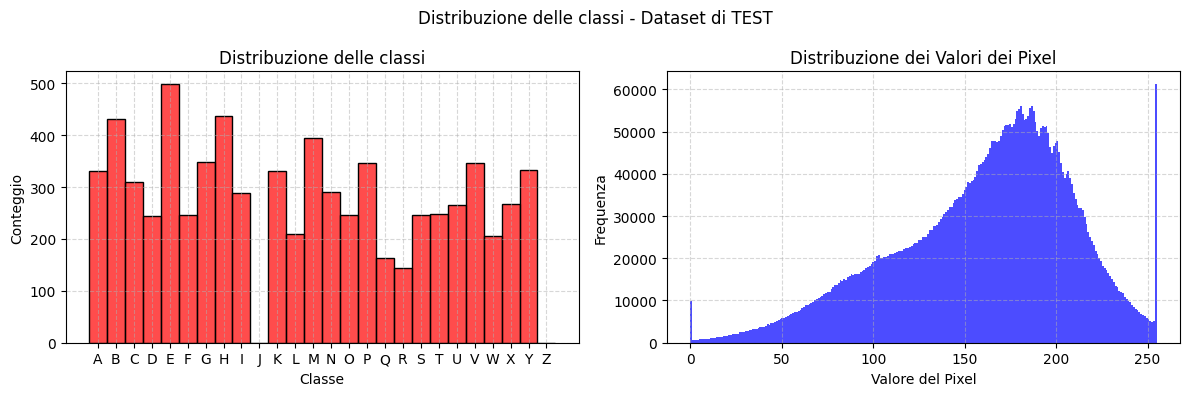

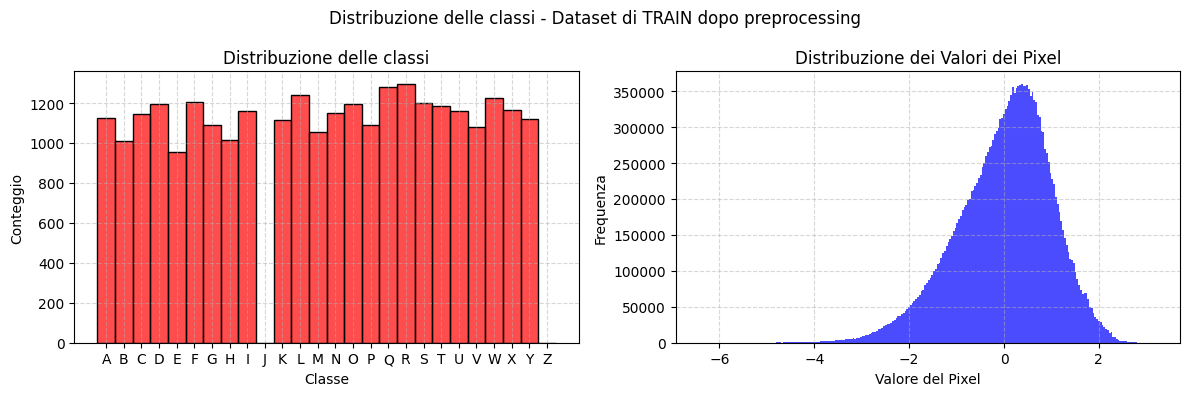

Shape dopo Preprocessing dei Dati: (27455, 784) (27455,) (7172, 784) (7172,)
Numero di features prima della PCA: (27455, 784)
Shape dopo Preprocessing PCA: (27455, 115) (27455,) (7172, 115) (7172,)

Training Naive Bayes...
Accuracy Naive Bayes: 0.61
F1-Score Naive Bayes: 0.62

Classification Report - Naive Bayes:

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       331
           1       0.87      0.74      0.80       432
           2       0.91      0.74      0.82       310
           3       0.70      0.77      0.73       245
           4       0.93      0.69      0.79       498
           5       0.79      0.67      0.73       247
           6       0.85      0.59      0.69       348
           7       0.90      0.67      0.77       436
           8       0.72      0.50      0.59       288
          10       0.64      0.40      0.49       331
          11       0.74      0.84      0.79       209
          12       0.54      0.45  

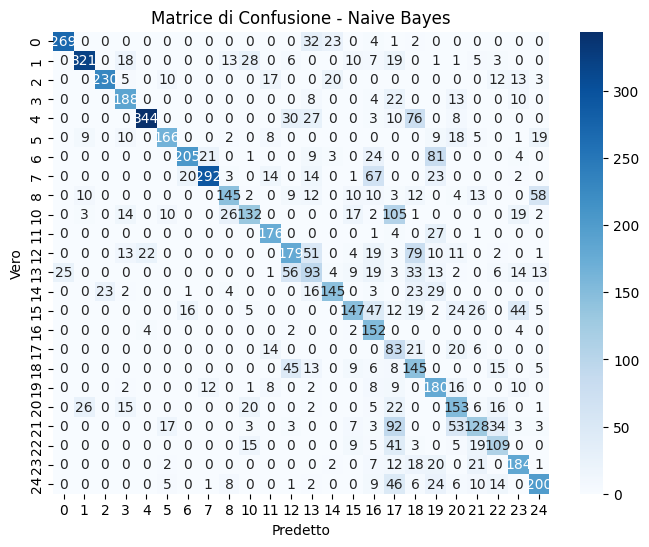


Training MLPClassifier1...
Accuracy MLPClassifier1: 0.79
F1-Score MLPClassifier1: 0.79

Classification Report - MLPClassifier1:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       331
           1       0.97      0.85      0.91       432
           2       1.00      0.99      1.00       310
           3       0.76      0.99      0.86       245
           4       0.91      0.96      0.93       498
           5       0.77      0.95      0.85       247
           6       0.89      0.77      0.82       348
           7       0.90      0.88      0.89       436
           8       0.88      0.78      0.83       288
          10       0.72      0.53      0.61       331
          11       0.69      1.00      0.82       209
          12       0.78      0.70      0.73       394
          13       0.71      0.65      0.68       291
          14       0.98      0.76      0.86       246
          15       0.95      1.00      0.98       347
     

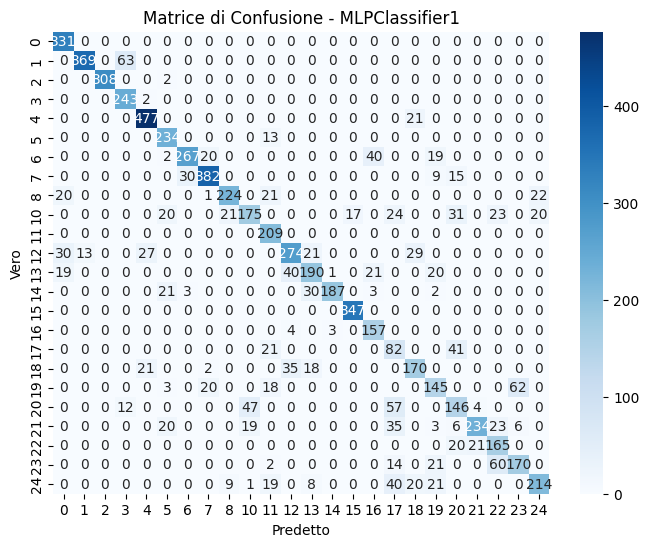


Training SVM...
Accuracy SVM: 0.86
F1-Score SVM: 0.87

Classification Report - SVM:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       331
           1       1.00      1.00      1.00       432
           2       0.92      1.00      0.96       310
           3       0.96      1.00      0.98       245
           4       0.95      1.00      0.97       498
           5       0.81      0.92      0.86       247
           6       0.94      0.95      0.94       348
           7       1.00      0.95      0.98       436
           8       0.80      0.85      0.83       288
          10       0.87      0.69      0.77       331
          11       0.92      0.99      0.95       209
          12       0.83      0.78      0.81       394
          13       0.90      0.66      0.76       291
          14       0.93      0.93      0.93       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00      

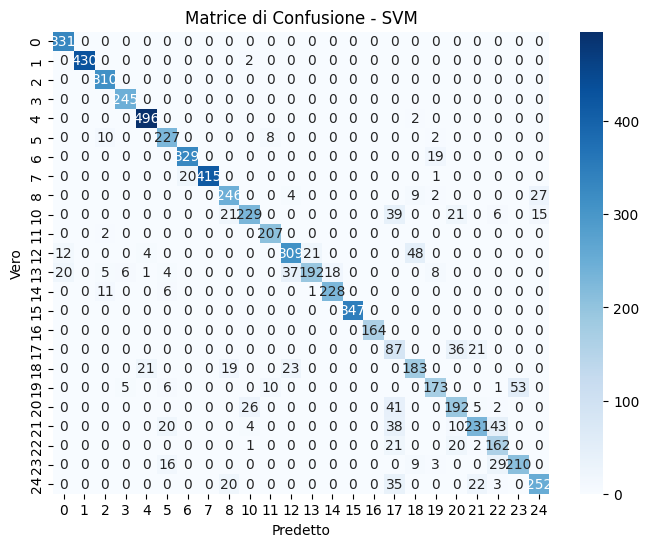


Training Decision Tree...
Accuracy Decision Tree: 0.49
F1-Score Decision Tree: 0.48

Classification Report - Decision Tree:

              precision    recall  f1-score   support

           0       0.68      0.93      0.78       331
           1       0.62      0.57      0.59       432
           2       0.69      0.66      0.68       310
           3       0.43      0.47      0.45       245
           4       0.76      0.70      0.73       498
           5       0.55      0.55      0.55       247
           6       0.48      0.48      0.48       348
           7       0.75      0.57      0.65       436
           8       0.17      0.18      0.18       288
          10       0.42      0.31      0.36       331
          11       0.57      0.77      0.65       209
          12       0.43      0.25      0.32       394
          13       0.35      0.25      0.29       291
          14       0.58      0.48      0.52       246
          15       0.75      0.77      0.76       347
         

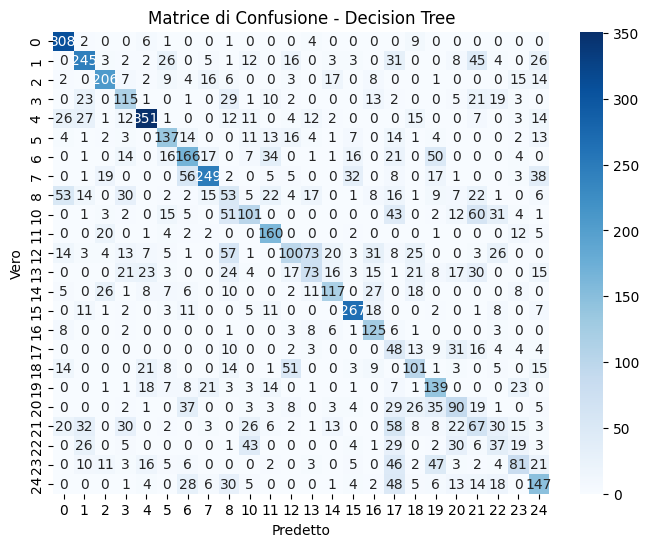


Miglior modello: SVM
Accuratezza: 0.86
F1-Score: 0.87



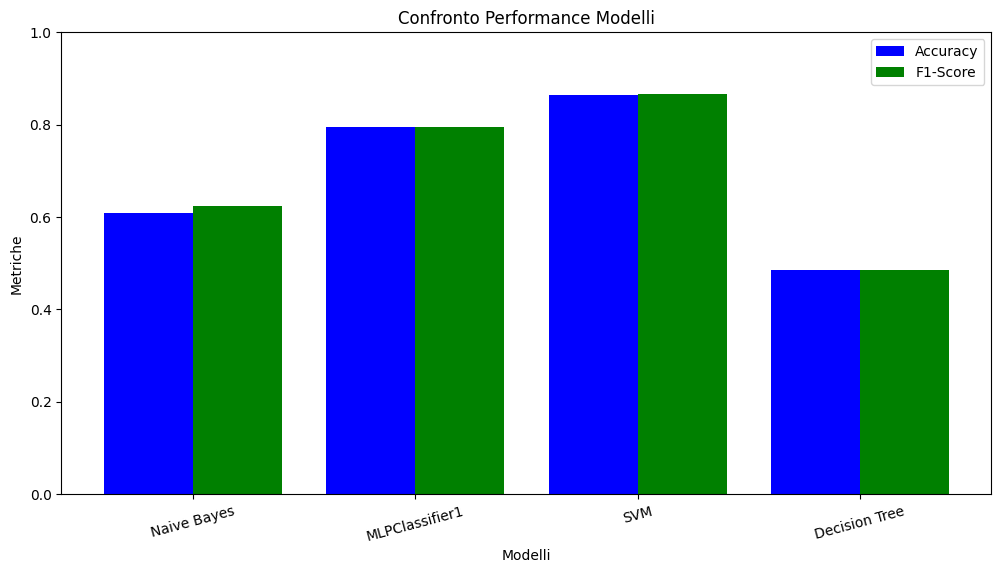


Risultati finali: {'Naive Bayes': {'accuracy': 0.6087562744004462, 'f1_score': 0.6240942621598057, 'model': GaussianNB()}, 'MLPClassifier1': {'accuracy': 0.7947573898494144, 'f1_score': 0.7946660497906682, 'model': MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=5000, random_state=42)}, 'SVM': {'accuracy': 0.8637757947573899, 'f1_score': 0.8652620400799846, 'model': SVC(probability=True, random_state=42)}, 'Decision Tree': {'accuracy': 0.4856385945343001, 'f1_score': 0.4844905546255896, 'model': DecisionTreeClassifier(max_depth=25, random_state=42)}}


In [72]:
# Input dei dataset in formato CSV
x_train, y_train, x_test, y_test = load_datasets(
    "sign_mnist_train.csv", 
    "sign_mnist_test.csv"
)

# EDA sui dataset di Train e Test    
perform_eda(x_train, y_train, "Dataset di TRAIN")
perform_eda(x_test, y_test, "Dataset di TEST")

# Preprocessing dei dati di Train
x_train, x_test = preprocess_data(x_train, x_test)
perform_eda(x_train, y_train, "Dataset di TRAIN dopo preprocessing")
print("Shape dopo Preprocessing dei Dati:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Applicazione della PCA sui dati di Train
x_train, x_test = PCA_preprocess(x_train, x_test)  
print("Shape dopo Preprocessing PCA:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

results, best_model = train_and_evaluate_models(x_train, y_train, x_test, y_test)
print("\nRisultati finali:", results)

In [84]:
def prepare_ASLimages(Test_imgages):
    
    Test_data = pd.read_csv("TestASL_images.csv")

    print("VISUALIZZAZIONE DATASET DI TEST")
    visualize_dataset(Test_data, "test")    

    x_test = Test_data.iloc[:,1:].values
    y_test = Test_data.iloc[:,0].values

    return x_test, y_test

    

In [83]:
def PCA_preprocess(x_train, n_components=115):
    '''
    Applica la PCA sui dati di addestramento e di test, riducendo la dimensionalità
    mantenendo una percentuale di varianza (default 95%).
    
    Args:
        x_train (np.array): features di train
        x_test (np.array): features di test
        n_components (float): la percentuale di varianza da mantenere
        
    Returns:
        tuple: x_train, x_test
    ''' 

    print(f"Numero di features prima della PCA: {x_train.shape}")
    
    pca = PCA(n_components=n_components)
    x_train = pca.fit_transform(x_train)
    
    return x_train

In [85]:
def test_ASLimages(model, labels, images): 

    # Predizioni
    predictions = model.predict(images)
    predicted_labels = [Lettere_keys[pred] for pred in predictions]

    #Visualizzazione dei risultati
    # Visualizzazione dei risultati
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle("Risultati del Test - Predizioni Modello", fontsize=16)

    for i, ax in enumerate(axes):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        true_label = labels[i]
        pred_label = predicted_labels[i]
        ax.set_title(f"V: {true_label}\nP: {pred_label}", fontsize=12)
        ax.axis('off')



 TEST MY IMAGES: 

VISUALIZZAZIONE DATASET DI TEST
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      0     144     143     141     141     141     140     140     139   
1     11     147     147     146     145     145     145     145     145   
2      8     151     149     146     145     143     142     141     143   
3     13     144     143     143     142     141     141     141     141   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     142  ...       181       174       160       225       242       240   
1     149  ...       202       200       202       190       174       174   
2     146  ...       193       195       186       186       178       183   
3     140  ...       173       166       160       152       220       241   

   pixel781  pixel782  pixel783  pixel784  
0       241       239       238       237  
1       231       239       240       237  
2       237       239       239       238  


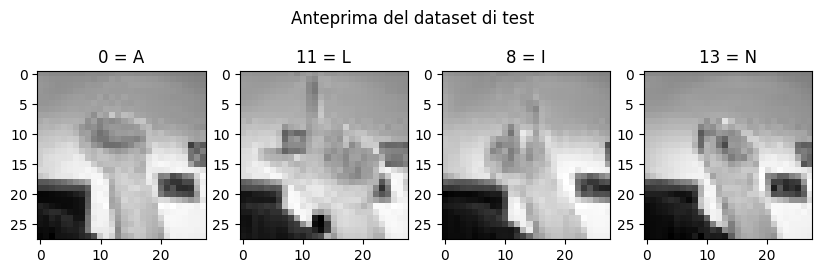

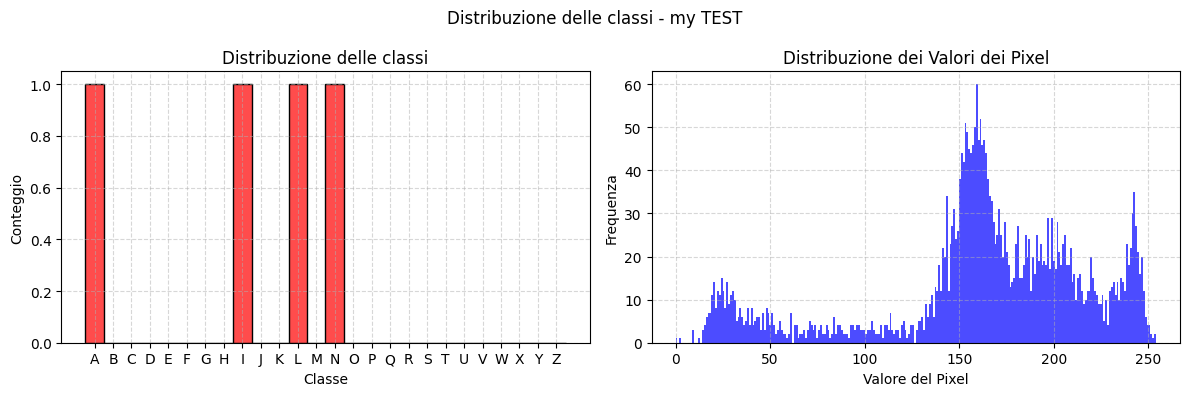

Numero di features prima della PCA: (4, 784)


ValueError: n_components=115 must be between 0 and min(n_samples, n_features)=4 with svd_solver='full'

In [86]:

print("\n TEST MY IMAGES: \n")

images, labels = prepare_ASLimages("TestASL")

perform_eda(images, labels, "my TEST")

test_ASLimages(best_model,['A','L','I','N'], images)


